<a href="https://colab.research.google.com/github/ab17254/ce888/blob/main/Assignment/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import os

sns.set_style('whitegrid')

### Functions to reload data as so that it is formatted correctly

In [2]:
!mkdir temp

In [3]:
def reload(df):
  if os.path.exists('temp/df.csv'):
    os.remove('temp/df.csv')
  df.to_csv('temp/df.csv')
  return(pd.read_csv('/content/temp/df.csv'))

In [4]:
def reload_del_index(df):
  if os.path.exists('temp/df.csv'):
    os.remove('temp/df.csv')
  df.to_csv('temp/df.csv', index=False)
  return(pd.read_csv('/content/temp/df.csv'))

## Load arrest dataset and processes

In [5]:
arrest_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/crime-justice-and-the-law/policing/number-of-arrests/latest/downloads/number-of-arrests.csv').content
arrest_df = pd.read_csv(io.StringIO(arrest_data.decode('utf-8')))
arrest_df = arrest_df.drop(columns=['Notes'])
arrest_df = arrest_df.dropna()
arrest_df = arrest_df[arrest_df['Age_Group'] == 'All']
arrest_df = arrest_df[arrest_df['Gender'] == 'All']
arrest_df.shape

(12144, 15)

In [6]:
'''
Purpose: Takes an location and filters the data so that it only shows data relating to that location
param location string: A string of the location the data needs to be filtered by
param df pandas.DataFrame: Dataframe downloaded from source
returns df_new pandas.DataFrame: Dataframe of filtered processed data
'''
def get_arrest_per_pop(location, df):
  df_new = df[df['Geography'] == location]
  df_new = df_new[df_new['Rate per 1,000 population by ethnicity, gender, and PFA'] != ' N/A ']
  df_new = df_new.pivot(index='Time', columns='Ethnicity' ,values='Rate per 1,000 population by ethnicity, gender, and PFA')
  # Used when working with total value of arrests to remove commas from values above 1,000 (changes 1,000 (str) to 1000 (int))
  # df_new = df_new.convert_dtypes()
  # df_new = df_new.apply(lambda x: x.str.replace(',', ''))
  df_new = df_new.apply(lambda x: x.str.replace('-','0'))
  df_new = df_new.fillna(0) #Set NA values to 0 - we are assuming there was no recorded arrests of that ethnicity in that year. Mean could be used but that would does not seem like a valid identifier
  df_new = df_new.astype(int)
  
  # Combines ethnicity's into ethnic groups and then divides this to make it per population
  df_new['Black'] = df_new['Black'] + df_new['Black African'] + df_new['Black Caribbean'] + df_new['Any other black background']
  df_new['Black'] = df_new['Black']/4
  df_new['White'] = df_new['White'] + df_new['White British'] + df_new['White Irish'] + df_new['Any other white background']
  df_new['White'] = df_new['White']/4
  df_new['Asian'] = df_new['Asian'] + df_new['Chinese'] + df_new['Indian'] + df_new['Bangladeshi'] + df_new['Pakistani'] + df_new['Any other asian']
  df_new['Asian'] = df_new['Asian']/6
  df_new['Mixed'] = df_new['Mixed'] + df_new['Mixed White and Asian'] + df_new['Mixed White and Black African'] + df_new['Mixed White and Black Caribbean'] + df_new['Any other mixed/multiple ethnic background']
  df_new['Mixed'] = df_new['Mixed']/5
  df_new['Other'] = df_new['Other'] + df_new['Any other ethnic group']
  df_new['Other'] = df_new['Other']/2
  df_new['All'] = (df_new['Black'] + df_new['White'] + df_new['Asian'] + df_new['Mixed'] + df_new['Other'])/5
  df_new = df_new.drop(columns=['Black African', 'Black Caribbean', 'Any other black background', 'White British', 'White Irish', 'Any other white background', 'Chinese', 'Indian', 'Bangladeshi', 'Pakistani', 'Any other asian', 'Mixed White and Asian', 'Mixed White and Black African', 'Mixed White and Black Caribbean', 'Any other mixed/multiple ethnic background', 'Any other ethnic group'])

  return df_new

In [7]:
arrest_df_all = get_arrest_per_pop('All', arrest_df)
#Large forces
arrest_df_manchester = get_arrest_per_pop('Greater Manchester', arrest_df)
arrest_df_london = get_arrest_per_pop('Metropolitan Police', arrest_df)
#Medium forces
arrest_df_essex = get_arrest_per_pop('Essex', arrest_df)
arrest_df_lancashire = get_arrest_per_pop('Lancashire', arrest_df)
#Small forces
arrest_df_suffolk = get_arrest_per_pop('Suffolk', arrest_df)
arrest_df_wiltshire = get_arrest_per_pop('Wiltshire', arrest_df)

## Plot arrests

Text(0.5, 1.0, 'Total arrests')

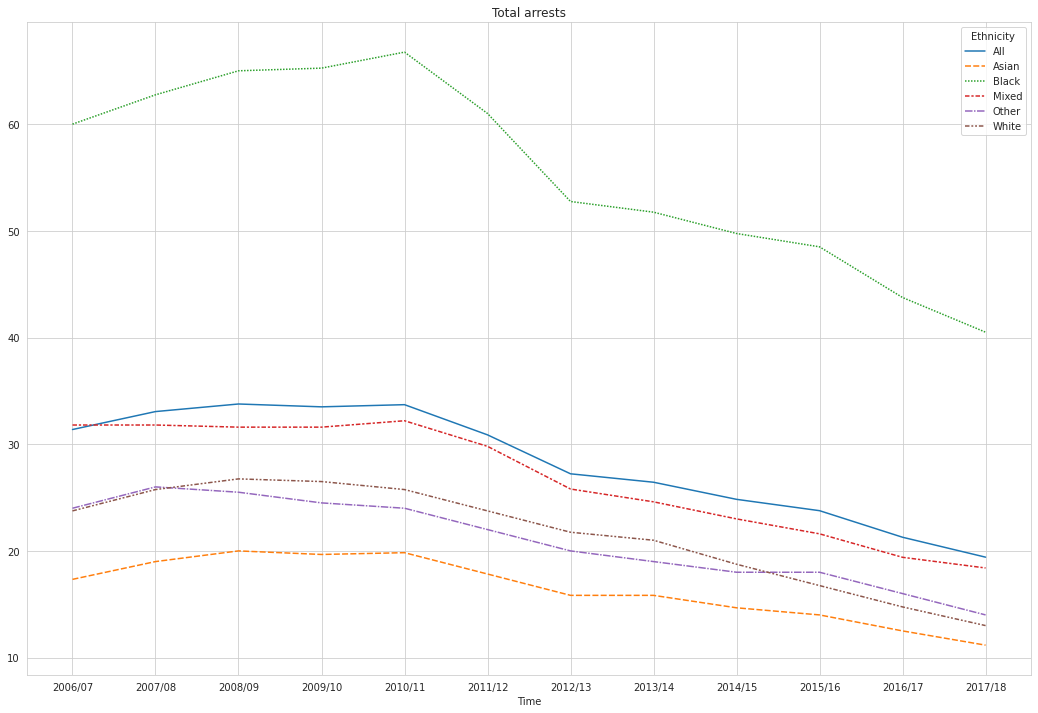

In [8]:
fig, ax = plt.subplots(figsize=(18,12), sharey='all')
sns.lineplot(data=arrest_df_all)
ax.set_title('Total arrests')

Text(0.5, 1.0, 'Wiltshire Arrests')

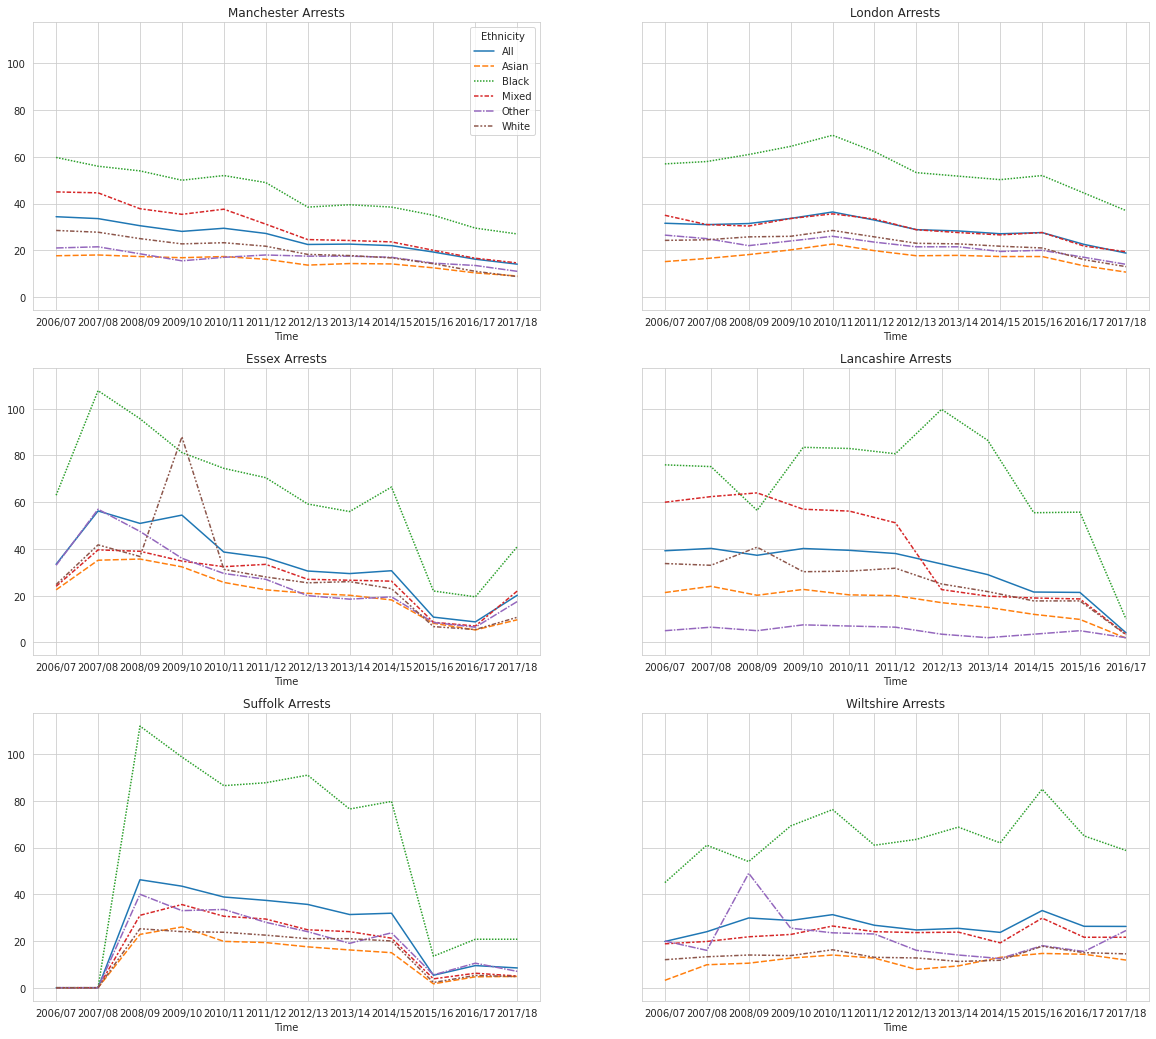

In [9]:
fig, ax = plt.subplots(3,2, figsize=(20,18), sharey='all')
sns.lineplot(data=arrest_df_manchester, ax=ax[0,0], legend=True)
sns.lineplot(data=arrest_df_london, ax=ax[0,1], legend=False)
sns.lineplot(data=arrest_df_essex, ax=ax[1,0], legend=False)
sns.lineplot(data=arrest_df_lancashire, ax=ax[1,1], legend=False)
sns.lineplot(data=arrest_df_suffolk, ax=ax[2,0], legend=False)
sns.lineplot(data=arrest_df_wiltshire, ax=ax[2,1], legend=False)
ax[0,0].set_title('Manchester Arrests')
ax[0,1].set_title('London Arrests')
ax[1,0].set_title('Essex Arrests')
ax[1,1].set_title('Lancashire Arrests')
ax[2,0].set_title('Suffolk Arrests')
ax[2,1].set_title('Wiltshire Arrests')


## Add Ethnicity of Officers to main dataset

In [10]:
officer_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/workforce-and-business/workforce-diversity/police-workforce/latest/downloads/by-ethnicity-over-time-police-officers.csv').content
officer_data = pd.read_csv(io.StringIO(officer_data.decode('utf-8')))

In [11]:
officer_data = officer_data.pivot(index='Time', columns='Ethnicity', values='Number of police officers (FTE) ')

In [12]:
officer_data = officer_data.drop(columns=['Unknown'])

In [13]:
officer_data = officer_data.rename(columns={'Other inc Chinese': 'Other Officers', 'Time': 'Date',
                                            'White': 'White Officers',
                                            'Black': 'Black Officers',
                                            'Asian': 'Asian Officers',
                                            'Mixed': 'Mixed Officers'})

In [14]:
officer_data

Ethnicity,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
Time,,,,,
2007,"2,111","1,350","1,419",632,"134,372"
2008,"2,231","1,371","1,525",656,"134,000"
2009,"2,472","1,427","1,699",689,"135,651"
2010,"2,607","1,446","1,844",745,"135,293"
2011,"2,582","1,442","1,838",754,"130,870"
2012,"2,607","1,420","1,871",766,"125,579"
2013,"2,563","1,361","1,865",749,"121,086"
2014,"2,665","1,352","1,922",776,"119,071"
2015,"2,795","1,373","2,028",785,"117,757"


In [15]:
officer_data = officer_data.convert_dtypes()
officer_data = officer_data.apply(lambda x: x.str.replace(',', ''))

In [16]:
officer_data = reload_del_index(officer_data).iloc[0:12]

In [17]:
arrest_df_all_re = reload(arrest_df_all)

In [18]:
data_all = pd.concat([arrest_df_all_re, officer_data], axis=1)

In [19]:
data_all

,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,2006/07,31.376667,17.333333,60.00,31.8,24.0,23.75,2111,1350,1419,632,134372
1,2007/08,33.060000,19.000000,62.75,31.8,26.0,25.75,2231,1371,1525,656,134000
2,2008/09,33.770000,20.000000,65.00,31.6,25.5,26.75,2472,1427,1699,689,135651
3,2009/10,33.503333,19.666667,65.25,31.6,24.5,26.50,2607,1446,1844,745,135293
4,2010/11,33.706667,19.833333,66.75,32.2,24.0,25.75,2582,1442,1838,754,130870
5,2011/12,30.876667,17.833333,61.00,29.8,22.0,23.75,2607,1420,1871,766,125579
6,2012/13,27.226667,15.833333,52.75,25.8,20.0,21.75,2563,1361,1865,749,121086
7,2013/14,26.436667,15.833333,51.75,24.6,19.0,21.00,2665,1352,1922,776,119071
8,2014/15,24.833333,14.666667,49.75,23.0,18.0,18.75,2795,1373,2028,785,117757
9,2015/16,23.770000,14.000000,48.50,21.6,18.0,16.75,2881,1433,2096,808,114437


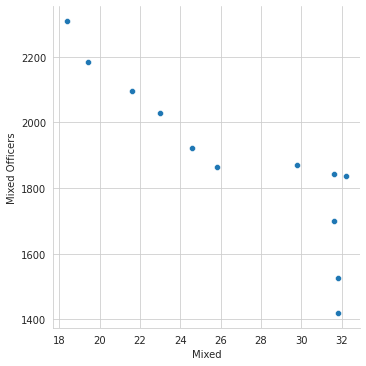

In [20]:
sns.relplot(x='Mixed', y='Mixed Officers', data=data_all)

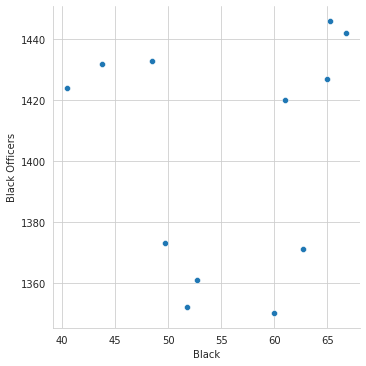

In [21]:
sns.relplot(x='Black', y='Black Officers', data=data_all)

More officers = less  arrests

correllation or casue?



## AI Bias dataset

In [22]:
arrest_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/crime-justice-and-the-law/policing/number-of-arrests/latest/downloads/number-of-arrests.csv').content
arrest_df = pd.read_csv(io.StringIO(arrest_data.decode('utf-8')))

In [23]:
# arrest_new = arrest_df[arrest_df['Geography'] == 'All']
arrest_new = arrest_df.drop(columns=['Measure','Time_type', 'Ethnicity_type', 'Gender_type','Age_Group_type','Geography_type', 'Population by ethnicity, gender, and PFA (based on 2011 Census)', 'Rate per 1,000 population by ethnicity, gender, and PFA', 'Proportion of arrests of this ethnicity, in this year, of this gender and in this police force area (excludes unreported)', 'Notes'])

In [24]:
arrest_new.index.name = 'index'

In [25]:
arrest_new.reset_index(level=0, inplace=True)


In [26]:
arrest_new = arrest_new.set_index(['index','Ethnicity','Gender'])

In [27]:
arrest_new = arrest_new.convert_dtypes()
arrest_new = arrest_new.apply(lambda x: x.str.replace(',', ''))

In [28]:
arrest_new

,,,Time,Age_Group,Geography,Number of arrests
index,Ethnicity,Gender,,,,
0,Asian,Female,2006/07,10 - 17 years,Avon and Somerset,10
1,Asian,Female,2006/07,10 - 17 years,Bedfordshire,25
2,Asian,Female,2006/07,10 - 17 years,Cambridgeshire,9
3,Asian,Female,2006/07,10 - 17 years,Cheshire,-
4,Asian,Female,2006/07,10 - 17 years,Cleveland,4
...,...,...,...,...,...,...
218587,Mixed White and Asian,All,2013/14,All,All,2906
218588,Mixed White and Asian,All,2014/15,All,All,2711
218589,Mixed White and Asian,All,2015/16,All,All,2532


## Save data

In [29]:
!mkdir data

In [30]:
arrest_df_all.to_csv('data/arrest_all.csv')
arrest_df_manchester.to_csv('data/arrest_manchester.csv')
arrest_df_london.to_csv('data/arrest_london.csv')
arrest_df_essex.to_csv('data/arrest_essex.csv')
arrest_df_lancashire.to_csv('data/arrest_lancashire.csv')
arrest_df_suffolk.to_csv('data/arrest_suffolk.csv')
arrest_df_wiltshire.to_csv('data/arrest_wiltshire.csv')
data_all.to_csv('data/data_all.csv')

arrest_new.to_csv('data/arrest_all_new.csv')

In [31]:
# Output file
!zip -r /content/data.zip /content/data/

  adding: content/data/ (stored 0%)
  adding: content/data/arrest_essex.csv (deflated 58%)
  adding: content/data/arrest_suffolk.csv (deflated 58%)
  adding: content/data/arrest_lancashire.csv (deflated 54%)
  adding: content/data/arrest_all.csv (deflated 60%)
  adding: content/data/data_all.csv (deflated 55%)
  adding: content/data/arrest_london.csv (deflated 61%)
  adding: content/data/arrest_all_new.csv (deflated 88%)
  adding: content/data/arrest_wiltshire.csv (deflated 59%)
  adding: content/data/arrest_manchester.csv (deflated 59%)
